### Baseline Attack Class on Logistic Regression Classifier For MNIST
Author: Ashe Magalhaes, ashe.magalhaes@gmail.com
#### Initialization of this code:  https://www.kaggle.com/allunia/how-to-attack-a-machine-learning-model/notebook

#### Set Up

In [40]:
import pandas as pd
import numpy as np
from sklearn import model_selection, linear_model, metrics
import matplotlib.pyplot as plt

In [30]:
'''
The label holds the true digit and the other columns all 
784 pixel of an image with 28 times 28 pixels
'''
df = pd.read_csv("data/train.csv")
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
y = df.label.values
X = df.drop("label",axis=1).values
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.4, random_state=0)

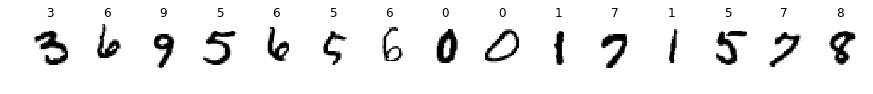

In [32]:
# A look at first digits of test set 
fig1, ax1 = plt.subplots(1,15, figsize=(15,10))
for i in range(15):
    ax1[i].imshow(X_test[i].reshape((28,28)), cmap="gray_r")
    ax1[i].axis('off')
    ax1[i].set_title(y_test[i])

### Attack class, 
Taken from https://www.kaggle.com/allunia/how-to-attack-a-machine-learning-model/notebook



In [33]:
class Attack:

    def __init__(self, model):
        self.fooling_targets = None
        self.model = model
    
    def prepare(self, X_train, y_train, X_test, y_test):
        self.images = X_test
        self.true_targets = y_test
        self.num_samples = X_test.shape[0]
        self.train(X_train, y_train)
        print("Model training finished.")
        self.test(X_test, y_test)
        print("Model testing finished. Initial accuracy score: " + str(self.initial_score))
    
    def set_fooling_targets(self, fooling_targets):
        self.fooling_targets = fooling_targets
    
    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        self.weights = self.model.coef_
        self.num_classes = self.weights.shape[0]

    def test(self, X_test, y_test):
        self.preds = self.model.predict(X_test)
        self.preds_proba = self.model.predict_proba(X_test)
        self.initial_score = metrics.accuracy_score(y_test, self.preds)
    
    def create_one_hot_targets(self, targets):
        self.one_hot_targets = np.zeros(self.preds_proba.shape)
        for n in range(targets.shape[0]):
            self.one_hot_targets[n, targets[n]] = 1
            
    def attack(self, attackmethod, epsilon):
        perturbed_images, highest_epsilon = self.perturb_images(epsilon, attackmethod)
        perturbed_preds = self.model.predict(perturbed_images)
        score = metrics.accuracy_score(self.true_targets, perturbed_preds)
        return perturbed_images, perturbed_preds, score, highest_epsilon
    
    def perturb_images(self, epsilon, gradient_method):
        perturbed = np.zeros(self.images.shape)
        max_perturbations = []
        for n in range(self.images.shape[0]):
            perturbation = self.get_perturbation(epsilon, gradient_method, self.one_hot_targets[n], self.preds_proba[n])
            perturbed[n] = self.images[n] + perturbation
            max_perturbations.append(np.max(perturbation))
        highest_epsilon = np.max(np.array(max_perturbations))
        return perturbed, highest_epsilon
    
    def get_perturbation(self, epsilon, gradient_method, target, pred_proba):
        gradient = gradient_method(target, pred_proba, self.weights)
        inf_norm = np.max(gradient)
        perturbation = epsilon/inf_norm * gradient
        return perturbation
    
    def attack_to_max_epsilon(self, attackmethod, max_epsilon):
        self.max_epsilon = max_epsilon
        self.scores = []
        self.epsilons = []
        self.perturbed_images_per_epsilon = []
        self.perturbed_outputs_per_epsilon = []
        for epsilon in range(0, self.max_epsilon):
            perturbed_images, perturbed_preds, score, highest_epsilon = self.attack(attackmethod, epsilon)
            self.epsilons.append(highest_epsilon)
            self.scores.append(score)
            self.perturbed_images_per_epsilon.append(perturbed_images)
            self.perturbed_outputs_per_epsilon.append(perturbed_preds)

In [34]:
model = linear_model.LogisticRegression(multi_class='multinomial', solver='lbfgs', fit_intercept=False)

This way we train our model on training data and we will obtain the initial accuracy score on test data. Later on we want to break down this score by perturbing the test data.

In [35]:
attack = Attack(model)
attack.prepare(X_train, y_train, X_test, y_test)

Model training finished.
Model testing finished. Initial accuracy score: 0.909345238095238


/Users/ashemagalhaes/miniconda3/envs/mlp2/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


#### We assumed that inputs and class memberships are independent and identically distributed.

In [43]:
weights = attack.weights
print(weights.shape)

num_classes = len(np.unique(y_train))
print(num_classes)

(10, 784)
10


We want to maximize the probability that the outputs do not match the targets.But we can add tiny perturbations to our input images such that we maximize our discrepancy function. Let's do that and for making things simpler we use the log

In [45]:
"""
Attack methods
"""

def calc_output_weighted_weights(output, w):
    for c in range(len(output)):
        if c == 0:
            weighted_weights = output[c] * w[c]
        else:
            weighted_weights += output[c] * w[c]
    return weighted_weights

def targeted_gradient(foolingtarget, output, w):
    ww = calc_output_weighted_weights(output, w)
    for k in range(len(output)):
        if k == 0:
            gradient = foolingtarget[k] * (w[k]-ww)
        else:
            gradient += foolingtarget[k] * (w[k]-ww)
    return gradient

def non_targeted_gradient(target, output, w):
    ww = calc_output_weighted_weights(output, w)
    for k in range(len(target)):
        if k == 0:
            gradient = (1-target[k]) * (w[k]-ww)
        else:
            gradient += (1-target[k]) * (w[k]-ww)
    return gradient

def non_targeted_sign_gradient(target, output, w):
    gradient = non_targeted_gradient(target, output, w)
    return np.sign(gradient)

In [46]:
"""
Adding tiny perturbations in input image
"""

attack.create_one_hot_targets(y_test)
attack.attack_to_max_epsilon(non_targeted_gradient, 30)
non_targeted_scores = attack.scores


In [50]:
eps = 16
attack.epsilons[eps]
example_images = attack.perturbed_images_per_epsilon[eps]
example_preds = attack.perturbed_outputs_per_epsilon[eps]
example_results = pd.DataFrame(data=attack.true_targets, columns=['y_true'])
example_results['y_fooled'] = example_preds
example_results['y_predicted'] = attack.preds
example_results['id'] = example_results.index.values
example_results.head()

,y_true,y_fooled,y_predicted,id
0,3,8,3,0
1,6,6,6,1
2,9,9,9,2
3,5,8,5,3
4,6,6,6,4


In [51]:
success_df = example_results[example_results.y_fooled != example_results.y_true]
success_df.head()

,y_true,y_fooled,y_predicted,id
0,3,8,3,0
3,5,8,5,3
5,5,9,0,5
6,6,2,6,6
14,8,5,8,14


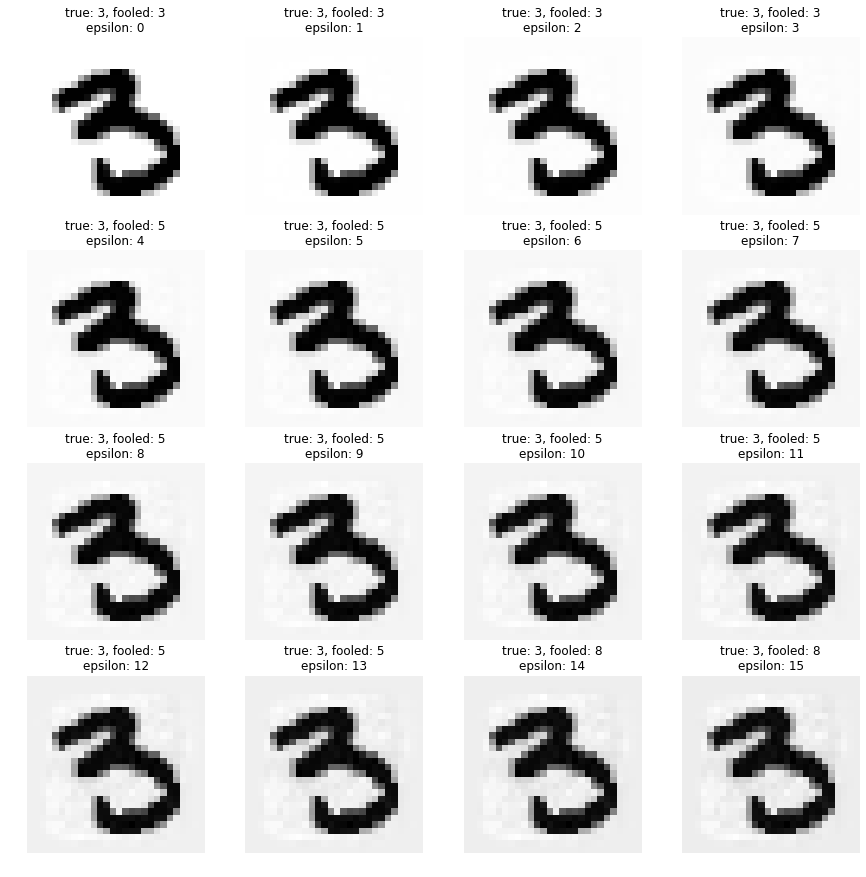

In [53]:
example_id = success_df.id.values[0]
fig2, ax2 = plt.subplots(4,4, figsize=(15,15))
for i in range(4):
    for j in range(4):
        image = attack.perturbed_images_per_epsilon[i*4 + j][example_id]
        y_fooled = attack.perturbed_outputs_per_epsilon[i*4 + j][example_id]
        epsilon = attack.epsilons[i*4 +j]
        ax2[i,j].imshow(image.reshape((28,28)), cmap="gray_r")
        ax2[i,j].axis('off')
        ax2[i,j].set_title("true: " + str(y_test[example_id]) + ", fooled: " + str(y_fooled)  + "\n" 
                           + "epsilon: " + str(np.int(epsilon)))

## FINDINGS: 

### Approach: Forcing the function to yield the maximum discrepance
We found out that each digit has its natural fooling target. For example 3 was likely predicted as 5 or 8 which makes sense as all three have "two bubbles" on top of each other as a sketch shape. You can see that 8 was a good fooling choice for several digits... interestingly for 1 as well. In addition we find that for some images both holds: 4 and 9 for example are possible in both ways.

### Approach:  Construct it such that outputs have to match a specific false target.
Even though we can see high background noise the true label is not destroyed. I can still see the true label with my eyes whereas the model predicts the desired fooling target (0 to 9, except true label). :-) That's cool.

### Approach: Jacboian Matrix Attack
We have found that we could express the perturbation by a masking of the Jacobian matrix. The letter tells us more generally how the outputs of all classes change with input perturbations. This is already a hint that we could built attacks and defenses on approaches based on the Jacobian. Besides the Fast Gradient Attack you can find a Jacobian-based approach as well
